In [1]:
import math
from typing import Optional
from botorch import fit_fully_bayesian_model_nuts
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor
from botorch.test_functions import Branin, Hartmann
from botorch.test_functions.sensitivity_analysis import Ishigami
from botorch.models.transforms import Standardize
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
import torch
from torch import Tensor
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [2]:
from mgp_models.acquisition import QBMGPAcquisitionFunction

In [3]:
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

def eval_nll(X:Tensor, Y:Tensor):
    Y = standardize(Y)
    gp = SingleTaskGP(X, Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return -mll.forward()


In [4]:
def get_candidate_pool(dim, size=1000):
    U = torch.rand(size, dim)
    return U

In [5]:
def get_test_set(synthetic_function, dim, size=1000):
    X_test = torch.rand(size, dim)
    Y_test = synthetic_function(X_test)
    return X_test, Y_test



In [6]:
def get_acq_values_pool(acq_function, candidates):
    acq_values = acq_function(candidates)
    best_index = torch.argmax(acq_values)
    candidates = candidates[best_index].unsqueeze(-1)
    return candidates.T, acq_values[best_index].unsqueeze(-1)

In [7]:
def eval_rmse(gp, test_X, test_Y, ll=None):
    posterior = gp.posterior(test_X, ll=ll)
    if ll is not None:
        Y_hat = posterior.best_mixture_mean
    else:
        Y_hat = posterior.mixture_mean
    return torch.sqrt(torch.mean((Y_hat-test_Y)**2))

In [8]:
def eval_nll(gp, test_X, test_Y, ll=None):
    posterior = gp.posterior(test_X, ll=ll)
    if ll is not None:
        Y_hat = posterior.best_mixture_mean
    else:
        Y_hat = posterior.mixture_mean
    sigma2 = torch.std(Y_hat).pow(2)
    p1 = 0.5*torch.log(2*math.pi*sigma2) 
    p2 = torch.sub(test_Y, Y_hat).pow(2).sum().div(2*sigma2)
    return p1+p2

In [9]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor

from botorch.acquisition import AnalyticAcquisitionFunction
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from mgp_models.fit_fully_bayesian import fit_fully_bayesian_mgp_model_nuts, fit_partially_bayesian_mgp_model

class BALMAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:


        posterior = self.model.posterior(X, ll= self.ll)
        return posterior.weighted_variance

class BQBCAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:


        posterior = self.model.posterior(X, ll= self.ll)
        return posterior.BQBC
    

class QBMGPAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:


        posterior = self.model.posterior(X, ll= self.ll)
        return posterior.QBMGP
    
class RandomAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:


        
        return torch.rand(X.size()[0])

In [10]:
tkwargs = {
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double,
}

In [13]:
torch.cuda.is_available()

False

In [11]:
N_INIT = 10
synthetic_function = Hartmann(noise_std=0.019).to(**tkwargs)

In [12]:
DIM = 6

# Evaluation budget
N_INIT = 10
N_ITERATIONS = 8 if not SMOKE_TEST else 1
BATCH_SIZE = 5 if not SMOKE_TEST else 1
print(f"Using a total of {N_INIT + BATCH_SIZE * N_ITERATIONS} function evaluations")
WARMUP_STEPS = 256 if not SMOKE_TEST else 32
NUM_SAMPLES = 128 if not SMOKE_TEST else 16
THINNING = 16

Using a total of 50 function evaluations


In [13]:
from torch.quasirandom import SobolEngine

In [133]:
from torch import Tensor
from math import pi
import torch 
from botorch.test_functions.synthetic import SyntheticTestFunction

class Gramacy1d(SyntheticTestFunction):

    dim = 1
    _bounds = [(0.5, 2.5)]

    def evaluate_true(self, X:Tensor) -> Tensor:
        t1 = torch.sin(10*pi*X).div(2*X)
        t2 = X-1
        t2 = t2.pow(4)
        t3 = t1+t2
        return t3.squeeze()
    
class Gramacy2d(SyntheticTestFunction):

    dim = 2
    _bounds = [(-2, 6), (-2, 6)]

    def evaluate_true(self, X:Tensor) -> Tensor:
        t = X[:,0]* torch.exp(-X[:,0]**2 - X[:,1]**2)
        return t


class Higdon(SyntheticTestFunction):

    dim = 1
    _bounds = [(0, 20)]

    def evaluate_true(self, X:Tensor) -> Tensor:
        t1 = torch.sin(pi*X.div(5))
        t2 = 0.2*torch.cos(4*pi*X.div(5))
        t3 = t1+t2
        t4 = X.div(10) -1 
        t5 = torch.where(X <= 10,t3, t4)
        return t5.squeeze()
    
def convert_bounds(tensor: Tensor, bounds, dim: int)-> Tensor:

    if bounds is not None:
        for i in range(dim):
            a, b = bounds[i]
            tensor[:, i] = a + (b - a) * tensor[:, i]
    return tensor
 
def get_candidate_pool(dim, bounds, size=1000):
    U = torch.rand(size, dim)
    U = convert_bounds(U, bounds, dim)
    return U

In [44]:
X = SobolEngine(dimension=2, scramble=True, seed=0).draw(3).to(**tkwargs)
Y = synthetic_function(X).unsqueeze(-1)
Y

RuntimeError: The size of tensor a (2) must match the size of tensor b (6) at non-singleton dimension 2

In [103]:

func = Higdon(0)
X = SobolEngine(dimension=1, scramble=True, seed=30).draw(1).to(**tkwargs)
X  = convert_bounds(X, [[-2,6],[-2, 6]],2)
print(X)
func(X).unsqueeze(-1)

IndexError: index 1 is out of bounds for dimension 1 with size 1

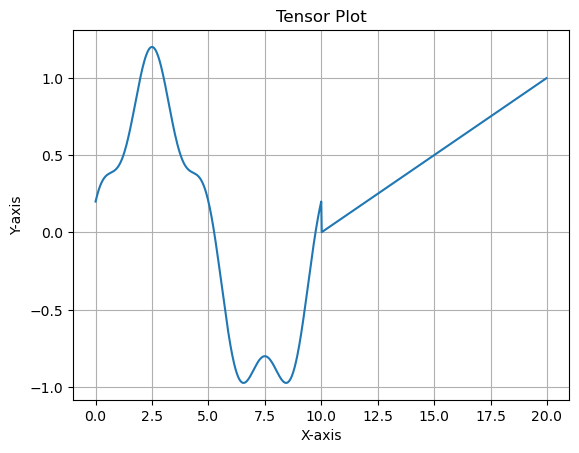

In [108]:
import matplotlib.pyplot as plt
xs = torch.arange(0, 20, 20/1000)
func = Higdon(0)
ys = func(xs)
xs_np = xs.numpy()
ys_np = ys.numpy()

# Plotting
plt.plot(xs_np, ys_np)  # Plot with markers
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Tensor Plot')
plt.grid(True)
plt.show()


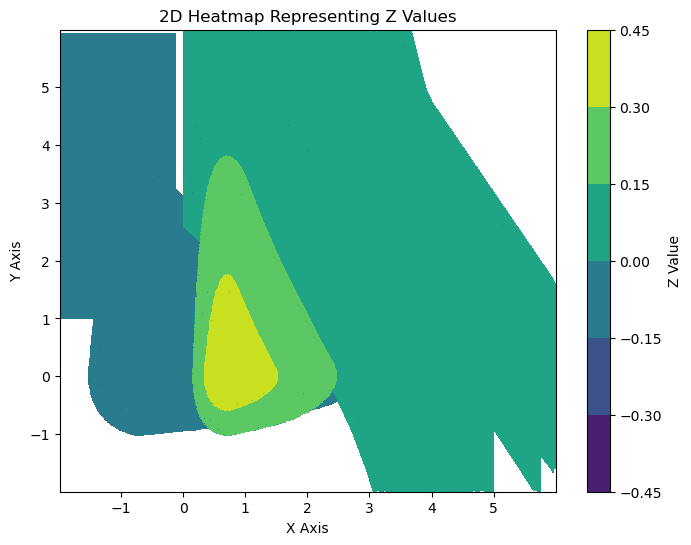

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
U= SobolEngine(dimension=2, scramble=True, seed=30).draw(1000).to(**tkwargs)
U  = convert_bounds(U, [[-2,6],[-2, 6]],2)
func = Gramacy2d(0)
zs = func(U)
xs_np = U[:,0].numpy()
ys_np = U[:,1].numpy()
X, Y = np.meshgrid(xs_np, ys_np)
X2 = X**2
Y2 = Y**2

Z = X*np.exp(-X2-Y2)
Z = np.round(Z, decimals=5)

# Creating a heatmap using the same X, Y, and Z data
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar(label='Z Value')

# Adding labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('2D Heatmap Representing Z Values')

# Showing the plot
plt.show()

tensor([[ 0.7565,  2.0830],
        [ 5.8877,  1.0313],
        [ 4.8381,  0.9021],
        ...,
        [-0.0537,  0.5790],
        [ 4.5816,  5.9501],
        [ 2.7052,  3.2297]])

In [30]:
#X[:0].mul(
#torch.exp(
X[:0]
#-X[:1].pow(2)
#    )
    #)
X[:0]

tensor([], size=(0, 2), dtype=torch.float64)

In [49]:
print(f"Best initial point: {Y.min().item():.3f}")

Best initial point: -0.723


In [33]:
for i in range(30):
    train_Y = -1 * Y  # Flip the sign since we want to minimize f(x)
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=X,
        train_Y=train_Y,
        train_Yvar=torch.full_like(train_Y, 1e-6),
        outcome_transform=Standardize(m=1),
    )
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    EI = qExpectedImprovement(model=gp, best_f=train_Y.max())
    candidates, acq_values = optimize_acqf(
        EI,
        bounds=torch.cat((torch.zeros(1, DIM), torch.ones(1, DIM))).to(**tkwargs),
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=1024,
    )

    Y_next = torch.cat([synthetic_function(x).unsqueeze(-1) for x in candidates]).unsqueeze(-1)
    if Y_next.min() < Y.min():
        ind_best = Y_next.argmin()
        x0, x1 = candidates[ind_best, :2].tolist()
        print(
            f"{i + 1}) New best: {Y_next[ind_best].item():.3f} @ "
            f"[{x0:.3f}, {x1:.3f}]"
        )
    X = torch.cat((X, candidates))
    Y = torch.cat((Y, Y_next))
    

KeyboardInterrupt: 

In [113]:
for i in range(30):
    train_Y = -1 * Y  # Flip the sign since we want to minimize f(x)
    gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        train_Yvar=torch.full_like(train_Y, 1e-6),
        outcome_transform=Standardize(m=1)
    )
    ll = fit_partially_bayesian_mgp_model(gp,16, 0.1, 300)


    EI = qExpectedImprovement(model=gp, best_f=train_Y.max())
    candidates, acq_values = optimize_acqf(
        EI,
        bounds=torch.cat((torch.zeros(1, DIM), torch.ones(1, DIM))).to(**tkwargs),
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=1024,
    )
    print(candidates.size())
    print(acq_values)

    Y_next = torch.cat([synthetic_function(x).unsqueeze(-1) for x in candidates]).unsqueeze(-1)
    print(Y_next.min())
    if Y_next.min() < Y.min():
        ind_best = Y_next.argmin()
        x0, x1 = candidates[ind_best, :2].tolist()
        print(
            f"{i + 1}) New best: {Y_next[ind_best].item():.3f} @ "
            f"[{x0:.3f}, {x1:.3f}]"
        )
    X = torch.cat((X, candidates))
    Y = torch.cat((Y, Y_next))

    gp

torch.Size([5, 6])
tensor(0.0551, dtype=torch.float64)
tensor(-2.2615, dtype=torch.float64)
1) New best: -2.262 @ [0.439, 1.000]


KeyboardInterrupt: 

In [54]:
poolU = get_candidate_pool(DIM, 1000)
X_test, Y_test = get_test_set(synthetic_function, DIM, 1000)

In [55]:
for i in range(60):
    train_Y = Y#-1 * Y  # Flip the sign since we want to minimize f(x)
    gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        #train_Yvar=torch.full_like(train_Y, 1e-6),
        outcome_transform=Standardize(m=1)
    )
    ll = fit_partially_bayesian_mgp_model(gp,16, 0.1, 300)
    print("fitted")

    acq_function = RandomAcquisitionFunction(gp, ll=ll)
    candidates, acq_values = get_acq_values_pool(acq_function, poolU)
    print("got candidate acq fucntion values")
    Y_next = synthetic_function(candidates).unsqueeze(-1)
    X = torch.cat((X, candidates))
    Y = torch.cat((Y, Y_next))
    metric = eval_rmse(gp, X_test, Y_test, ll=ll)
    nll = eval_nll(gp, X_test, Y_test, ll=ll)
    print(f"new rmse: {metric}")
    print(f"new nll: {nll}")

fitted
got candidate acq fucntion values
new rmse: 0.4608780715368461
new nll: 1889673.9490026436
fitted
got candidate acq fucntion values
new rmse: 0.4428370018293291
new nll: 2068910.0744951132
fitted
got candidate acq fucntion values
new rmse: 0.42679456014051764
new nll: 2639472.098718729
fitted
got candidate acq fucntion values
new rmse: 0.4376861414832068
new nll: 2207042.9022772633
fitted
got candidate acq fucntion values
new rmse: 0.4550690608324991
new nll: 2182680.6799233356
fitted
got candidate acq fucntion values
new rmse: 0.4558323980541004
new nll: 2194041.0090358155
fitted
got candidate acq fucntion values
new rmse: 0.41454031760409166
new nll: 3441339.290094278
fitted
got candidate acq fucntion values
new rmse: 0.41388487326861534
new nll: 3701850.593381067
fitted
got candidate acq fucntion values
new rmse: 0.5216030627533218
new nll: 1086831.38533671
fitted
got candidate acq fucntion values
new rmse: 0.5390157338708681
new nll: 1013685.5619948253
fitted
got candidate a

KeyboardInterrupt: 

In [206]:
for i in range(60):
    #train_Y = -1 * Y  # Flip the sign since we want to minimize f(x)
    gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        #train_Yvar=torch.full_like(train_Y, 1e-6),
        outcome_transform=Standardize(m=1)
    )
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )
    ll=None
    print("fitted")

    acq_function = QBMGPAcquisitionFunction(gp, ll=ll)
    candidates, acq_values = get_acq_values_pool(acq_function, poolU)
    print("got candidate acq fucntion values")
    Y_next = synthetic_function(candidates).unsqueeze(-1)
    X = torch.cat((X, candidates))
    Y = torch.cat((Y, Y_next))
    metric = eval_rmse(gp, X_test, Y_test, ll=ll)
    print(f"new rmse: {metric}")

fitted
got candidate acq fucntion values
new rmse: 0.667949109411193
fitted
got candidate acq fucntion values
new rmse: 0.7228340346773029
fitted
got candidate acq fucntion values
new rmse: 0.587937729548038
fitted
got candidate acq fucntion values
new rmse: 0.6688772918386043
fitted
got candidate acq fucntion values
new rmse: 0.5594300114354412
fitted
got candidate acq fucntion values
new rmse: 0.6485458515965595
fitted
got candidate acq fucntion values
new rmse: 0.6377990622304346
fitted
got candidate acq fucntion values
new rmse: 0.8102664429349081
fitted
got candidate acq fucntion values
new rmse: 0.7879583989219806
fitted
got candidate acq fucntion values
new rmse: 0.7557525807354915
fitted
got candidate acq fucntion values
new rmse: 0.7477674895572223
fitted
got candidate acq fucntion values
new rmse: 0.6797097198195262
fitted
got candidate acq fucntion values
new rmse: 0.7190220474292218
fitted
got candidate acq fucntion values
new rmse: 0.678136391920127
fitted
got candidate ac

KeyboardInterrupt: 

In [166]:
Y = torch.cat((Y, Y_next.unsqueeze(-1)))

In [168]:
Y.size()

torch.Size([11, 1])

In [3]:
from typing import List
from typing import Any, Dict

from botorch.acquisition.input_constructors import acqf_input_constructor


@acqf_input_constructor(BQBCAcquisitionFunction)
def construct_inputs_scalarized_ucb(
    model: Model,
    ll:  Optional[Tensor] = None,
    **kwargs: Any,
) -> Dict[str, Any]:
    return {
        "model": model,
    }

In [ ]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
            model_kwargs={"seed": 999},  # Any kwargs you want passed into the model
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            # `acquisition_options` specifies the set of additional arguments to pass into the input constructor.
            model_kwargs={
                "botorch_acqf_class": BQBCAcquisitionFunction,
            },
        ),
    ]
)

In [ ]:
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import  Branin


# Initialize the client - AxClient offers a convenient API to control the experiment
ax_client = AxClient(generation_strategy=gs)
# Setup the experiment
ax_client.create_experiment(
    name="branin_test_experiment",
    parameters=[
        {
            "name": f"x{i+1}",
            "type": "range",
            # It is crucial to use floats for the bounds, i.e., 0.0 rather than 0.
            # Otherwise, the parameter would
            "bounds": [0.0, 1.0],
        }
        for i in range(2)
    ],
    objectives={
        "branin": ObjectiveProperties(minimize=True),
    },
)
# Setup a function to evaluate the trials
branincurrin = Branin()


def evaluate(parameters):
    x = torch.tensor([[parameters.get(f"x{i+1}") for i in range(2)]])
    bc_eval = Branin(x).squeeze().tolist()
    # In our case, standard error is 0, since we are computing a synthetic function.
    return {"branin": (bc_eval[0], 0.0)}

In [ ]:
for i in range(10):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))